In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Introduction

This project involves developing a random forest model that predicts property prices based on a set 
of training data. First, we prepare the data by filling NA values by simple imputation 
methods. Then, we analyze the variables histogram and scatterplot to determine whether 
they need transformation. Lastly, we build the random forest model using the ranger package. 
 
The prediction error will be evaluated using RMLSE (Root Mean Squared Logarithmic Error)

# Data Pre-processing

First, checking for outliers, we see that there are properties with zero rooms, 
bathrooms, or kitchens. This could indicate errors when the data is recorded. Therefore, 
we will remove these observations.

In [5]:
# Loading Data
path = r"C:\Users\maian\OneDrive - University of Waterloo\Documents\UW\Projects\Data Sets\Random Forest\Training Data.csv"
dtrain = pd.read_csv(path)

In [7]:
dtrain.head(5)

,bathrm,hf_bathrm,heat,ac,rooms,bedrm,ayb,yr_rmdl,eyb,stories,...,roof,intwall,kitchens,fireplaces,landarea,latitude,longitude,nbhd,ward,quadrant
0,2,0,Forced Air,Y,6,3,1940.0,2011.0,1967,2.00,...,Slate,Hardwood,1.0,1,5473,40.748876,-74.124393,D9,Ward 5,NE
1,3,0,Hot Water Rad,Y,6,4,1933.0,2012.0,1972,2.25,...,Slate,Hardwood,1.0,2,7964,40.780493,-74.207416,B2,Ward 4,NW
2,2,0,Warm Cool,Y,7,2,1956.0,1978.0,1970,1.00,...,Comp Shingle,Hardwood,1.0,2,6750,40.664722,-74.095686,D2,Ward 7,SE
3,3,1,Warm Cool,Y,9,4,1977.0,2005.0,1993,2.00,...,Shake,Hardwood,2.0,2,7848,40.756657,-74.195369,C3,Ward 3,NW
4,2,1,Hot Water Rad,N,8,4,1923.0,NaN,1950,2.00,...,Slate,Hardwood,1.0,1,6250,40.785275,-74.173505,F1,Ward 4,NW


In [33]:
dtrain = dtrain[(dtrain['rooms'] != 0) & (dtrain['bathrm'] != 0) & (dtrain['bedrm'] != 0) & (dtrain['kitchens'].isna() == False)]
print(len(dtrain)) #seems like we removed 3 observations with no rooms

5994


How about NA values?

In [13]:
print(dtrain.isna().sum())

bathrm           0
hf_bathrm        0
heat             0
ac               0
rooms            0
bedrm            0
ayb             17
yr_rmdl       2407
eyb              0
stories          4
saledate         0
price            0
gba              0
style            0
grade            0
cndtn            0
extwall          0
roof             0
intwall          0
kitchens         1
fireplaces       0
landarea         0
latitude         0
longitude        0
nbhd             0
ward             0
quadrant        32
dtype: int64


It seems that we have quite a lot of NA values, we will consider one variable at a time. But first, do we really need the exact date of sales for each property? I will only keep the year and remove the dates. This way, we can treat this value as numerical

In [14]:
dtrain['saledate'] = pd.to_datetime(dtrain['saledate'])
dtrain['saledate'] = dtrain['saledate'].dt.year
dtrain['saledate'].head(5)

0    2013
1    2017
2    2015
3    2015
4    1993
Name: saledate, dtype: int32

That looks much better. Now, ayb is the year that the property was first built. To fill this value, we will use the average age of the other properties, then deduct the age from saledate.

In [17]:
avgAge = (dtrain['saledate'] - dtrain['ayb']).mean(skipna=True)
dtrain['ayb'].fillna(avgAge, inplace=True)
dtrain['ayb'].isna().sum() #Look at that! We have no missing value!

0

yr_rmdl is the year that the propety was remodelled. If the value is NA, then we can assume that the property has never been remodelled, and we can use ayb value instead.

In [19]:
dtrain['yr_rmdl'].fillna(dtrain['ayb'],inplace=True)
dtrain['yr_rmdl'].isna().sum()

0

The number of stories that were missing can potentially be extracted from style. Let's create a function for that

In [20]:
def extract_stories(style):
    style = style.lower()
    if "story" in style:
        word = style.split()
        return float(word[0])
    elif "bi" in style:
        return 2
    elif "split" in style:
        return 1.5
    else: 
        return 1

In [22]:
dtrain['stories'].fillna(dtrain['style'].apply(extract_stories), inplace = True)
dtrain['stories'].isna().sum()

0

Next, let's look at the coordinates of these properties to see how they are classified into quadrants. The black points are missing values

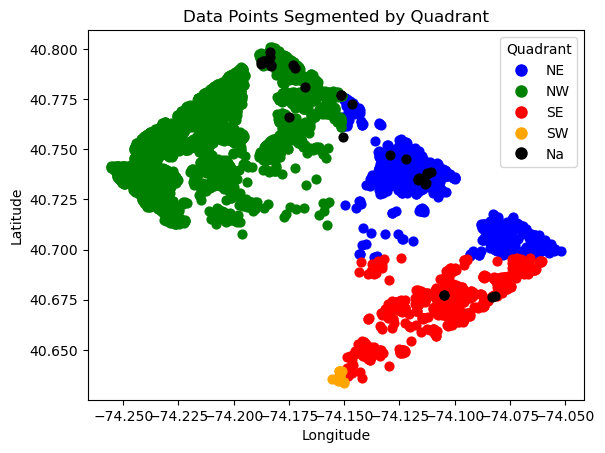

In [23]:
color_dict = {'NE': 'blue', 'NW': 'green', 'SE': 'red', 'SW': 'orange', 'Na': 'black'}

# Plotting
fig, ax = plt.subplots()
for quad, color in color_dict.items():
    if quad == 'Na':
        subset_data = dtrain[dtrain['quadrant'].isna()]
    else:
        subset_data = dtrain[dtrain['quadrant'] == quad]
    ax.scatter(subset_data['longitude'], subset_data['latitude'], label=quad, color=color, s=40)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Properties Segmented by Quadrant')

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_dict[quad]) for quad in color_dict]
labels = color_dict.keys()
plt.legend(handles, labels, title='Quadrant')

plt.show()

This seems like a perfect opportunity to apply k-nearest neighbor to fill these missing values, since we already have their coordinates.

In [25]:
from sklearn.neighbors import KNeighborsClassifier

def fill_quadrant_knn(data, k):
    complete_data = data[~data['quadrant'].isna()][["latitude", "longitude"]]
    complete_labels = data.loc[~data['quadrant'].isna(), 'quadrant']
    missing_data = data[data['quadrant'].isna()][["latitude", "longitude"]]

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(complete_data, complete_labels)
    knn_result = knn.predict(missing_data)

    data.loc[data['quadrant'].isna(), 'quadrant'] = knn_result
    return data

# Assuming 'dtrain' is your DataFrame and 'labels' is a list of quadrant labels
dtrain = fill_quadrant_knn(dtrain, 5)

labels = ["NE", "NW", "SE"]
for i, label in enumerate(labels, start=1):
    dtrain['quadrant'] = np.where(dtrain['quadrant'] == i, label, dtrain['quadrant'])
    
dtrain['quadrant'].isna().sum() #look at that! we just did a textbook case of KNN!

0

It seems that we finally finished data pre-processing! At last, let's double check and move onto building our model

In [34]:
print(dtrain.isna().sum().sum())

0
